In [2]:
import re
import pandas as pd
from typing import  Literal,List,Any
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.types import Command
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict, Annotated
from langchain_core.prompts.chat import ChatPromptTemplate
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field, field_validator
from langchain_core.messages import HumanMessage,AIMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv


In [3]:
load_dotenv()


True

In [4]:
openai_model=ChatOpenAI(model="gpt-4o-mini")

In [5]:
openai_model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CTUn13l2v8YNUJ3Ku3mxsOVbSHKfo', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--bc411659-c4b7-4160-85fb-cfb2ac4a83d6-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
class DateTimeModel(BaseModel):
    date: str = Field(description="Properly formatted date", pattern=r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$')

    @field_validator("date")
    def check_format_date(cls, v):
        if not re.match(r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$', v):  # Ensures 'DD-MM-YYYY HH:MM' format
            raise ValueError("The date should be in format 'DD-MM-YYYY HH:MM'")
        return v

In [7]:
class DateModel(BaseModel):
    date: str = Field(description="Properly formatted date", pattern=r'^\d{2}-\d{2}-\d{4}$')

    @field_validator("date")
    def check_format_date(cls, v):
        if not re.match(r'^\d{2}-\d{2}-\d{4}$', v):  # Ensures DD-MM-YYYY format
            raise ValueError("The date must be in the format 'DD-MM-YYYY'")
        return v

In [8]:
class IdentificationNumberModel(BaseModel):
    id: int = Field(description="Identification number (7 or 8 digits long)")
    @field_validator("id")
    def check_format_id(cls, v):
        if not re.match(r'^\d{7,8}$', str(v)):  # Convert to string before matching
            raise ValueError("The ID number should be a 7 or 8-digit number")
        return v

In [9]:
@tool
def check_availability_by_doctor(desired_date:DateModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Checking the database if we have availability for the specific doctor.
    The parameters should be mentioned by the user in the query
    """
    df = pd.read_csv(r"../data/doctor_availability.csv")
    
    #print(df)
    
    df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])
    
    rows = list(df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == desired_date.date)&(df['doctor_name'] == doctor_name)&(df['is_available'] == True)]['date_slot_time'])

    if len(rows) == 0:
        output = "No availability in the entire day"
    else:
        output = f'This availability for {desired_date.date}\n'
        output += "Available slots: " + ', '.join(rows)

    return output

In [10]:
# Example usage:
date_instance = DateModel(date="03-09-2024")
print(date_instance)

date='03-09-2024'


In [11]:
print(check_availability_by_doctor.invoke({"desired_date": date_instance, "doctor_name": "kevin anderson"}))

This availability for 03-09-2024
Available slots: 08:00, 08:30, 11:30, 12:00, 12:30, 13:00, 14:00, 14:30, 15:00, 15:30, 16:00, 16:30


In [12]:
@tool
def check_availability_by_specialization(desired_date:DateModel, specialization:Literal["general_dentist", "cosmetic_dentist", "prosthodontist", "pediatric_dentist","emergency_dentist","oral_surgeon","orthodontist"]):
    """
    Checking the database if we have availability for the specific specialization.
    The parameters should be mentioned by the user in the query
    """
    #Dummy data
    df = pd.read_csv(r"../data/doctor_availability.csv")
    df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])
    rows = df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == desired_date.date) & (df['specialization'] == specialization) & (df['is_available'] == True)].groupby(['specialization', 'doctor_name'])['date_slot_time'].apply(list).reset_index(name='available_slots')

    if len(rows) == 0:
        output = "No availability in the entire day"
    else:
        def convert_to_am_pm(time_str):
            # Split the time string into hours and minutes
            time_str = str(time_str)
            hours, minutes = map(int, time_str.split(":"))
            
            # Determine AM or PM
            period = "AM" if hours < 12 else "PM"
            
            # Convert hours to 12-hour format
            hours = hours % 12 or 12
            
            # Format the output
            return f"{hours}:{minutes:02d} {period}"
        output = f'This availability for {desired_date.date}\n'
        for row in rows.values:
            output += row[1] + ". Available slots: \n" + ', \n'.join([convert_to_am_pm(value)for value in row[2]])+'\n'

    return output

In [13]:
# Example usage:
date_instance = DateModel(date="03-09-2024")
print(date_instance)

date='03-09-2024'


In [14]:
print(check_availability_by_specialization.invoke({"desired_date": date_instance, "specialization": "orthodontist"}))

This availability for 03-09-2024
kevin anderson. Available slots: 
8:00 AM, 
8:30 AM, 
11:30 AM, 
12:00 PM, 
12:30 PM, 
1:00 PM, 
2:00 PM, 
2:30 PM, 
3:00 PM, 
3:30 PM, 
4:00 PM, 
4:30 PM



In [15]:
## Tools For Booking agent
@tool
def reschedule_appointment(old_date:DateTimeModel, new_date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Rescheduling an appointment.
    The parameters MUST be mentioned by the user in the query.
    """
    #Dummy data
    df = pd.read_csv(r"../data/doctor_availability.csv")
    available_for_desired_date = df[(df['date_slot'] == new_date.date)&(df['is_available'] == True)&(df['doctor_name'] == doctor_name)]
    if len(available_for_desired_date) == 0:
        return "Not available slots in the desired period"
    else:
        cancel_appointment.invoke({'date':old_date, 'id_number':id_number, 'doctor_name':doctor_name})
        set_appointment.invoke({'desired_date':new_date, 'id_number': id_number, 'doctor_name': doctor_name})
        return "Successfully rescheduled for the desired time"

In [16]:
Old_Date_Time = DateTimeModel(date="05-08-2024 08:30")
Old_Date_Time

DateTimeModel(date='05-08-2024 08:30')

In [17]:
New_Date_Time = DateTimeModel(date="28-03-2024 14:30")
New_Date_Time

DateTimeModel(date='28-03-2024 14:30')

In [18]:
IDNumber = IdentificationNumberModel(id=1000082)
IDNumber

IdentificationNumberModel(id=1000082)

In [19]:
print(reschedule_appointment.invoke({"old_date": Old_Date_Time,"new_date": New_Date_Time,"id_number":IDNumber, "doctor_name": "kevin anderson"}))

Not available slots in the desired period


In [20]:
@tool
def cancel_appointment(date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Canceling an appointment.
    The parameters MUST be mentioned by the user in the query.
    """
    df = pd.read_csv(r"../data/doctor_availability.csv")
    case_to_remove = df[(df['date_slot'] == date.date)&(df['patient_to_attend'] == id_number.id)&(df['doctor_name'] == doctor_name)]
    if len(case_to_remove) == 0:
        return "You don´t have any appointment with that specifications"
    else:
        df.loc[(df['date_slot'] == date.date) & (df['patient_to_attend'] == id_number.id) & (df['doctor_name'] == doctor_name), ['is_available', 'patient_to_attend']] = [True, None]
        df.to_csv(f"../data/doctor_availability.csv", index = False)

        return "Successfully cancelled"


In [21]:
Date = DateTimeModel(date="07-08-2024 08:30")
Date

DateTimeModel(date='07-08-2024 08:30')

In [22]:
IDNumber = IdentificationNumberModel(id=1000097)
IDNumber

IdentificationNumberModel(id=1000097)

In [23]:
print(cancel_appointment.invoke({"date": Date,"id_number":IDNumber,"doctor_name":"john doe"}))

You don´t have any appointment with that specifications


In [24]:
@tool
def set_appointment(desired_date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Set appointment or slot with the doctor.
    The parameters MUST be mentioned by the user in the query.
    """
    df = pd.read_csv(r"../data/doctor_availability.csv")
   
    from datetime import datetime
    def convert_datetime_format(dt_str):
        # Parse the input datetime string
        #dt = datetime.strptime(dt_str, "%Y-%m-%d %H:%M")
        dt = datetime.strptime(dt_str, "%d-%m-%Y %H:%M")
        
        # Format the output as 'DD-MM-YYYY H.M' (removing leading zero from hour only)
        return dt.strftime("%d-%m-%Y %#H.%M")
    
    case = df[(df['date_slot'] == convert_datetime_format(desired_date.date))&(df['doctor_name'] == doctor_name)&(df['is_available'] == True)]
    if len(case) == 0:
        return "No available appointments for that particular case"
    else:
        df.loc[(df['date_slot'] == convert_datetime_format(desired_date.date))&(df['doctor_name'] == doctor_name) & (df['is_available'] == True), ['is_available','patient_to_attend']] = [False, id_number.id]
        df.to_csv(f"../data/doctor_availability.csv", index = False)

        return "Succesfully done"

In [25]:
Date = DateTimeModel(date="07-08-2024 08:30")
Date

DateTimeModel(date='07-08-2024 08:30')

In [26]:
IDNumber = IdentificationNumberModel(id=1000097)
IDNumber

IdentificationNumberModel(id=1000097)

In [27]:
print(set_appointment.invoke({"desired_date":Date,"id_number":IDNumber,"doctor_name":"john doe"}))

No available appointments for that particular case


In [28]:
class Router(TypedDict):
    next: Literal["information_node","booking_node","FINISH"]
    reasoning: str

In [29]:
class AgentState(TypedDict):
    messages: Annotated[list[Any], add_messages]
    id_number: int
    next:str
    query: str
    current_reasoning: str

In [30]:
members_dict = {'information_node':'specialized agent to provide information related to availability of doctors or any FAQs related to hospital.','booking_node':'specialized agent to only to book, cancel or reschedule appointment'}

In [31]:
members_dict

{'information_node': 'specialized agent to provide information related to availability of doctors or any FAQs related to hospital.',
 'booking_node': 'specialized agent to only to book, cancel or reschedule appointment'}

In [32]:
options = list(members_dict.keys()) + ["FINISH"]

In [33]:
options

['information_node', 'booking_node', 'FINISH']

In [34]:
worker_info = '\n\n'.join([f'WORKER: {member} \nDESCRIPTION: {description}' for member, description in members_dict.items()]) + '\n\nWORKER: FINISH \nDESCRIPTION: If User Query is answered and route to Finished'

In [35]:
print(worker_info)

WORKER: information_node 
DESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.

WORKER: booking_node 
DESCRIPTION: specialized agent to only to book, cancel or reschedule appointment

WORKER: FINISH 
DESCRIPTION: If User Query is answered and route to Finished


In [36]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between following workers. "
    "### SPECIALIZED ASSISTANT:\n"
    f"{worker_info}\n\n"
    "Your primary role is to help the user make an appointment with the doctor and provide updates on FAQs and doctor's availability. "
    "If a customer requests to know the availability of a doctor or to book, reschedule, or cancel an appointment, "
    "delegate the task to the appropriate specialized workers. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
    "UTILIZE last conversation to assess if the conversation should end you answered the query, then route to FINISH "
     )

In [37]:
print(system_prompt)

You are a supervisor tasked with managing a conversation between following workers. ### SPECIALIZED ASSISTANT:
WORKER: information_node 
DESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.

WORKER: booking_node 
DESCRIPTION: specialized agent to only to book, cancel or reschedule appointment

WORKER: FINISH 
DESCRIPTION: If User Query is answered and route to Finished

Your primary role is to help the user make an appointment with the doctor and provide updates on FAQs and doctor's availability. If a customer requests to know the availability of a doctor or to book, reschedule, or cancel an appointment, delegate the task to the appropriate specialized workers. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH.UTILIZE last conversation to assess if the conversation should end you answered 

In [38]:
def supervisor_node(state:AgentState) -> Command[Literal['information_node', 'booking_node', '__end__']]:
    print("**************************below is my state right after entering****************************")
    print(state)
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"user's identification number is {state['id_number']}"},
    ] + state["messages"]
    
    print("***********************this is my message*****************************************")
    print(messages)
    
    # query = state['messages'][-1].content if state["messages"] else ""
    query = ''
    if len(state['messages']) == 1:
        query = state['messages'][0].content
      
    print("************below is my query********************")    
    print(query)
    
    response = openai_model.with_structured_output(Router).invoke(messages)
    
    goto = response["next"]
    
    print("********************************this is my goto*************************")
    print(goto)
    
    print("********************************")
    print(response["reasoning"])
          
    if goto == "FINISH":
        goto = END
        
    print("**************************below is my state****************************")
    print(state)
    
    if query:
        return Command(goto=goto, update={'next': goto, 
                                          'query': query, 
                                          'current_reasoning': response["reasoning"],
                                          'messages': [HumanMessage(content=f"user's identification number is {state['id_number']}")]
                        })
    return Command(goto=goto, update={'next': goto, 
                                      'current_reasoning': response["reasoning"]}
                   )

In [39]:
def information_node(state:AgentState) -> Command[Literal['supervisor']]:
    print("*****************called information node************")
    
    system_prompt = "You are specialized agent to provide information related to availability of doctors or any FAQs related to hospital based on the query. You have access to the tool.\n Make sure to ask user politely if you need any further information to execute the tool.\n For your information, Always consider current year is 2024."
    
    system_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    system_prompt
                ),
                (
                    "placeholder", 
                    "{messages}"
                ),
            ]
        )
    
    information_agent = create_react_agent(model=openai_model,tools=[check_availability_by_doctor,check_availability_by_specialization] ,prompt=system_prompt)
    
    result = information_agent.invoke(state)
    
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="information_node")
                #HumanMessage(content=result["messages"][-1].content, name="information_node")
            ]
        },
        goto="supervisor",
    )

In [40]:
def booking_node(state:AgentState) ->  Command[Literal['supervisor']]:
    
    print("*****************called booking node************")
    
    system_prompt = "You are specialized agent to set, cancel or reschedule appointment based on the query. You have access to the tool.\n Make sure to ask user politely if you need any further information to execute the tool.\n For your information, Always consider current year is 2024."
    
    system_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    system_prompt
                ),
                (
                    "placeholder", 
                    "{messages}"
                ),
            ]
        )
    booking_agent = create_react_agent(model=openai_model,tools=[set_appointment,cancel_appointment,reschedule_appointment],prompt=system_prompt)

    result = booking_agent.invoke(state)
    
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="booking_node")
                #HumanMessage(content=result["messages"][-1].content, name="booking_node")
            ]
        },
        goto="supervisor",
    )

In [41]:
graph = StateGraph(AgentState)

In [42]:
graph.add_node("supervisor", supervisor_node)

In [43]:
graph.add_node("information_node", information_node)

In [44]:
graph.add_node("booking_node", booking_node)

In [45]:
graph.add_edge(START, "supervisor")

In [46]:
app = graph.compile()

In [47]:
import langgraph

graph = app.get_graph()
print(graph)

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'supervisor': Node(id='supervisor', name='supervisor', data=supervisor(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'information_node': Node(id='information_node', name='information_node', data=information_node(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'booking_node': Node(id='booking_node', name='booking_node', data=booking_node(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='supervisor', data=None, conditional=False), Edge(source='booking_node', target='supervisor', data=None, conditional=True), Edge(source='information_node', target='supervisor', data=None, conditional=True), Edge(source='supervisor', target

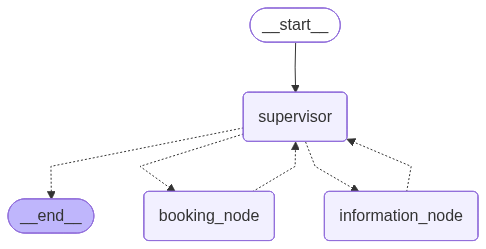

In [48]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [49]:
inputs = [
        HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 8 PM?')
    ]

In [50]:
state = {'messages': inputs,'id_number':10232303}


In [53]:
result = app.invoke(state)
result

**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 8 PM?', additional_kwargs={}, response_metadata={}, id='74baaff9-5f20-4fab-ad59-b4aa3858cd84')], 'id_number': 10232303}
***********************this is my message*****************************************
[{'role': 'system', 'content': "You are a supervisor tasked with managing a conversation between following workers. ### SPECIALIZED ASSISTANT:\nWORKER: information_node \nDESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.\n\nWORKER: booking_node \nDESCRIPTION: specialized agent to only to book, cancel or reschedule appointment\n\nWORKER: FINISH \nDESCRIPTION: If User Query is answered and route to Finished\n\nYour primary role is to help the user make an appointment with the doctor and provide updates on FAQs 

{'messages': [HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 8 PM?', additional_kwargs={}, response_metadata={}, id='74baaff9-5f20-4fab-ad59-b4aa3858cd84'),
  HumanMessage(content="user's identification number is 10232303", additional_kwargs={}, response_metadata={}, id='9d282b53-1d18-4d16-9263-5590bbbff844'),
  AIMessage(content='I can check the availability of a general dentist on 8 August 2024, but I do not have the capability to make bookings. Please confirm if you would like me to proceed with checking the availability for that date.', additional_kwargs={}, response_metadata={}, name='information_node', id='c357449b-d14a-480c-a478-c8af6ec1bf2a'),
  AIMessage(content='On 8 August 2024, I found the following available slots for general dentists:\n\n**Emily Johnson:**\n- 8:00 AM\n- 8:30 AM\n- 10:00 AM\n- 10:30 AM\n- 11:00 AM\n- 11:30 AM\n- 12:00 PM\n- 12:30 PM\n- 1:30 PM\n- 2:30 PM\n- 3:30 PM\n- 4:30 PM\n\n**John Doe:**\n- 8:00

In [52]:
result["messages"][-1].content

'Please let me know which dentist and available time slot you would like to book for your appointment on 8th August 2024, and I will proceed with the booking!'